In [1]:
import torch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Transformer model implementation
class Transformer(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, num_heads, dropout):
        super(Transformer, self).__init__()

        self.encoder = Encoder(input_size, hidden_size, num_layers, num_heads, dropout)
        self.decoder = Decoder(output_size, hidden_size, num_layers, num_heads, dropout)
        self.output_linear = nn.Linear(hidden_size, output_size)

    def forward(self, input, target):
        encoder_output = self.encoder(input)
        decoder_output = self.decoder(target, encoder_output)
        output = self.output_linear(decoder_output)
        return output


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_heads, dropout):
        super(Encoder, self).__init__()

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.positional_encoding = PositionalEncoding(hidden_size, dropout)
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(hidden_size, num_heads, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, input):
        embedded_input = self.embedding(input)
        scaled_input = embedded_input * torch.sqrt(embedded_input.size(-1))
        input_with_position = self.positional_encoding(scaled_input)

        output = input_with_position
        for encoder_layer in self.encoder_layers:
            output = encoder_layer(output)

        return output


class EncoderLayer(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout):
        super(EncoderLayer, self).__init__()

        self.multihead_attention = MultiHeadAttention(hidden_size, num_heads, dropout)
        self.feedforward = FeedForward(hidden_size, dropout)
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        attention_output = self.multihead_attention(input, input)
        residual1 = input + self.dropout(attention_output)
        norm1_output = self.layer_norm1(residual1)

        ff_output = self.feedforward(norm1_output)
        residual2 = norm1_output + self.dropout(ff_output)
        norm2_output = self.layer_norm2(residual2)

        return norm2_output


class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size, num_layers, num_heads, dropout):
        super(Decoder, self).__init__()

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.positional_encoding = PositionalEncoding(hidden_size, dropout)
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(hidden_size, num_heads, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, target, encoder_output):
        embedded_target = self.embedding(target)
        scaled_target = embedded_target * torch.sqrt(embedded_target.size(-1))
        target_with_position = self.positional_encoding(scaled_target)

        output = target_with_position
        for decoder_layer in self.decoder_layers:
            output = decoder_layer(output, encoder_output)

        return output


class DecoderLayer(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout):
        super(DecoderLayer, self).__init__()

        self.masked_multihead_attention = MultiHeadAttention(hidden_size, num_heads, dropout)
        self.multihead_attention = MultiHeadAttention(hidden_size, num_heads, dropout)
        self.feedforward = FeedForward(hidden_size, dropout)
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size)
        self.layer_norm3 = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, target, encoder_output):
        masked_attention_output = self.masked_multihead_attention(target, target)
        residual1 = target + self.dropout(masked_attention_output)
        norm1_output = self.layer_norm1(residual1)

        attention_output = self.multihead_attention(norm1_output, encoder_output)
        residual2 = norm1_output + self.dropout(attention_output)
        norm2_output = self.layer_norm2(residual2)

        ff_output = self.feedforward(norm2_output)
        residual3 = norm2_output + self.dropout(ff_output)
        norm3_output = self.layer_norm3(residual3)

        return norm3_output


class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout):
        super(MultiHeadAttention, self).__init__()

        self.hidden_size = hidden_size
        self.num_heads = num_heads

        self.query_linear = nn.Linear(hidden_size, hidden_size)
        self.key_linear = nn.Linear(hidden_size, hidden_size)
        self.value_linear = nn.Linear(hidden_size, hidden_size)
        self.output_linear = nn.Linear(hidden_size, hidden_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key):
        batch_size = query.size(0)

        query_transformed = self.query_linear(query)
        key_transformed = self.key_linear(key)
        value_transformed = self.value_linear(key)

        query_transformed = query_transformed.view(batch_size * self.num_heads, -1, self.hidden_size // self.num_heads).transpose(0, 1)
        key_transformed = key_transformed.view(batch_size * self.num_heads, -1, self.hidden_size // self.num_heads).transpose(0, 1)
        value_transformed = value_transformed.view(batch_size * self.num_heads, -1, self.hidden_size // self.num_heads).transpose(0, 1)

        attention_scores = torch.matmul(query_transformed, key_transformed.transpose(1, 2))
        attention_scores = attention_scores / torch.sqrt(torch.tensor(self.hidden_size // self.num_heads, dtype=torch.float32))

        attention_probs = nn.functional.softmax(attention_scores, dim=-1)
        attention_probs = self.dropout(attention_probs)

        context = torch.matmul(attention_probs, value_transformed)
        context = context.transpose(0, 1).contiguous().view(batch_size, -1, self.hidden_size)

        output = self.output_linear(context)

        return output


class FeedForward(nn.Module):
    def __init__(self, hidden_size, dropout):
        super(FeedForward, self).__init__()

        self.linear1 = nn.Linear(hidden_size, 4 * hidden_size)
        self.linear2 = nn.Linear(4 * hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        output = self.linear1(input)
        output = torch.relu(output)
        output = self.dropout(output)
        output = self.linear2(output)

        return output


class PositionalEncoding(nn.Module):
    def __init__(self, hidden_size, dropout, max_length=5000):
        super(PositionalEncoding, self).__init__()

        self.dropout = nn.Dropout(dropout)

        position = torch.arange(0, max_length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_size, 2) * -(math.log(10000.0) / hidden_size))
        pe = torch.zeros(max_length, hidden_size)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe)

    def forward(self, input):
        input = input + self.pe[:input.size(0), :]
        return self.dropout(input)

In [2]:
import torch.nn as nn
import math
class Embedding(nn.Module):
    def __init__(self,num_embeddings,embedding_dim):
        self.num_embeddings=num_embeddings
        self.embedding_dim=embedding_dim
        self.embedding=nn.Embedding(num_embeddings,embedding_dim)
    def forward(self,x):
        return self.embedding(x)*math.sqrt(self.embedding_dim)

In [41]:
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, embedding_dim,dropout,max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.embedding_dim = embedding_dim
        self.dropout=nn.Dropout(dropout)
        
        # Create constant 'pe' matrix with shape (max_len, d_model)
        pe = torch.zeros(max_len, embedding_dim)
        
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * -(torch.log(torch.tensor(10000.0)) / embedding_dim))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        # Add positional encoding to input tensor
        x = x + self.pe[:, :x.size(1)].requires_grad_(False)
        return self.dropout(x)

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder,decoder,linear,softmax) -> None:
        super().__init__(*args, **kwargs)
        self.encoder=encoder
        self.decoder=decoder
        self.linear=nn.Linear()

    def forward(self,input,output):
        encoded_input=self.encoder(input)
        decoder_output=self.decoder(encoded_input,output)
        x=self.linear(decoder_output)
        return nn.Softmax(x)

In [52]:
from torch import nn
class FeedForward(nn.Module):
    def __init__(self, input_size,output_size) -> None:
        super().__init__()
        self.l1 = nn.Linear(input_size,5)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(5,output_size)

    def forward(self,x):
        output = self.l1(x) 
        output = self.relu(output)
        output = self.l2(output)
        return output

In [ ]:
class encoder_n_multiple(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.FeedForward=FeedForward()
        self.norm=nn.LayerNorm()
        self.MultiHead=MultiHead()
    def forward(self,x):
        Multihead=self.MultiHead(x,x,x)
        x=self.norm(Multihead)+x
        x=self.FeedForward(x)
        return self.norm(x)+x

In [ ]:
class encoder(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.encoder_n_multiple=clone(encoder_n_multiple(),N)
        self.embedding=Embedding()
        self.psotionaEncdoing=PositionalEncoding
    def forward(self,x)
        x=self.embedding(x)
        x=self.psotionaEncdoing(x)+x
        x=self.encoder_n_multiple(x)
        return x

In [ ]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML
from diffusion_utilities import *


In [1]:
pip install snowflake-snowpark-python

  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.3
    Uninstalling urllib3-2.0.3:
      Successfully uninstalled urllib3-2.0.3
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\61401\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [1]:
from snowflake.snowpark.functions import avg

In [2]:
from snowflake.snowpark import Session

In [ ]:
https://vx25867.ap-southeast-2.snowflakecomputing.com

In [6]:
connection_parameters = {
    "account": "vx25867.ap-southeast-2",
    "user": "RezaHoss",
    "password": "Mohammad1234",
}  

new_session = Session.builder.configs(connection_parameters).create()

In [10]:
A=new_session.sql('select * from CITIBIKE.PUBLIC.TRIPS limit 10')

In [12]:
def double(x:int)->int:
    return 2*x

In [13]:
A.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"TRIPDURATION"  |"STARTTIME"                 |"STOPTIME"                  |"START_STATION_ID"  |"START_STATION_NAME"          |"START_STATION_LATITUDE"  |"START_STATION_LONGITUDE"  |"END_STATION_ID"  |"END_STATION_NAME"             |"END_STATION_LATITUDE"  |"END_STATION_LONGITUDE"  |"BIKEID"  |"MEMBERSHIP_TYPE"                     |"USERTYPE"  |"BIRTH_YEAR"  |"GENDER"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [7]:
import snowflake.snowpark as snowpark
from snowflake.snowpark.functions import col

def main(session: new_session): 
    # Your code goes here, inside the "main" handler.
    tableName = 'information_schema.packages'
    dataframe = session.table(tableName).filter(col("language") == 'python')

    # Print a sample of the dataframe to standard output.
    dataframe.show()

    # Return value will appear in the Results tab.
    return dataframe

In [8]:
main(new_session)

SnowparkSQLException: (1304): 01ad9199-3201-8305-0001-4c3a0002d03a: 090105 (22000): Cannot perform SELECT. This session does not have a current database. Call 'USE DATABASE', or use a qualified name.

In [ ]:
new_session.close()  

In [4]:
import pyodbc
# Trusted Connection to Named Instance
connection = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=DESKTOP-VJJUB30;DATABASE=AdventureWorks2022;Trusted_Connection=yes;')

In [5]:
cursor=connection.cursor()
cursor.execute("select top 100 * from AdventureWorks2022.HumanResources.Employee where JobTitle like 'production%' and MaritalStatus='M' and HireDate>='2000-01-01'and HireDate<=GETDATE()")

In [8]:
connection.close()

In [10]:
pip install sqlalchemy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\61401\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [15]:
import pandas as pd
from sqlalchemy import create_engine
engine = create_engine('mssql+pyodbc://DESKTOP-VJJUB30/AdventureWorks2022?driver=ODBC+Driver+17+for+SQL+Server')

In [16]:
engine.connect()

In [22]:
engine.dispose()

In [23]:
df = pd.read_sql(
      'SELECT [CustomerID]\
      ,[PersonID]\
      ,[StoreID]\
      ,[TerritoryID]\
      ,[AccountNumber]\
      ,[ModifiedDate]\
  FROM [Sales].[Customer]',
  engine,
  index_col='CustomerID')

In [24]:
df

,PersonID,StoreID,TerritoryID,AccountNumber,ModifiedDate
CustomerID,,,,,
1,NaN,934.0,1,AW00000001,2014-09-12 11:15:07.263
2,NaN,1028.0,1,AW00000002,2014-09-12 11:15:07.263
3,NaN,642.0,4,AW00000003,2014-09-12 11:15:07.263
4,NaN,932.0,4,AW00000004,2014-09-12 11:15:07.263
5,NaN,1026.0,4,AW00000005,2014-09-12 11:15:07.263
...,...,...,...,...,...
30114,1985.0,1986.0,7,AW00030114,2014-09-12 11:15:07.263
30115,1987.0,1988.0,6,AW00030115,2014-09-12 11:15:07.263
30116,1989.0,1990.0,4,AW00030116,2014-09-12 11:15:07.263


In [25]:
https://boards.greenhouse.io/vgw/jobs/6814326002?gh_src=bfc37dd62us

PersonID                             1985.0
StoreID                              1986.0
TerritoryID                               7
AccountNumber                    AW00030114
ModifiedDate     2014-09-12 11:15:07.263000
Name: 30114, dtype: object

In [1]:
pip install pymc

Note: you may need to restart the kernel to use updated packages.  Downloading pytensor-2.12.3-cp39-cp39-win_amd64.whl (1.4 MB)



You should consider upgrading via the 'c:\Users\61401\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


  Created wheel for cons: filename=cons-0.4.6-py3-none-any.whl size=9118 sha256=998f80eadd42159cb550532c3ffd8c0311d94cb54d567e9fb12a74288d0ed7b8
  Stored in directory: c:\users\61401\appdata\local\pip\cache\wheels\56\8e\eb\130d313bbaf36c97915634104d81fb7119332331ce32dca02e
  Created wheel for logical-unification: filename=logical_unification-0.4.6-py3-none-any.whl size=13953 sha256=28c85845ffc23cb8b7752055e3fc1c1a2cc098e40323a3f88e54815b285dccf5
  Stored in directory: c:\users\61401\appdata\local\pip\cache\wheels\c0\b5\eb\4af72f29fe7c242c96064dcc7f0c0925e879f02ef0a2858627
  Created wheel for etuples: filename=etuples-0.3.9-py3-none-any.whl size=12666 sha256=db65eefef40d8f9bbf6df0882d69010367eb98427bb33878266eaa4971b84123
  Stored in directory: c:\users\61401\appdata\local\pip\cache\wheels\39\61\89\eea4bbeb6d803a2a803e1ca4eac3c05ef89157c72a72dfe1e2
  Created wheel for miniKanren: filename=miniKanren-1.0.3-py3-none-any.whl size=23954 sha256=47b66c092ad94b60ff910fa68e7562fb3159fcbdfc0586b

In [ ]:
import pymc as pm
from pymc_

In [ ]:
Model Evaluation: Various statistical measures are used to evaluate the performance and validity of the MMM model.
These may include metrics such as R-squared (coefficient of determination), adjusted R-squared, significance tests for 
coefficients, p-values, standard errors, and residual analysis.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
automatc_samples=np.random.multivariate_normal([0,0],[[1,0.5],[0.5,1]],100000)

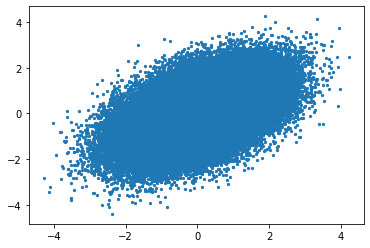

In [5]:
plt.scatter(automatc_samples[:,0],automatc_samples[:,1],s=5)

In [19]:
import random
x0=random.uniform(-4,4)
y0=random.uniform(-4,4)
x=[]
y=[]
x.append(x0)
y.append(y0)
for i in range(10000):
    x.append(np.random.normal(y[i]/2,np.sqrt(3/4),1)[0])
    y.append(np.random.normal(x[i+1]/2,np.sqrt(3/4),1)[0])



(array([   4.,    9.,   31.,   91.,  230.,  464.,  763., 1151., 1433.,
        1627., 1493., 1109.,  794.,  451.,  200.,  100.,   38.,    6.,
           4.,    3.]),
 array([-3.71585071, -3.32413947, -2.93242823, -2.54071699, -2.14900575,
        -1.7572945 , -1.36558326, -0.97387202, -0.58216078, -0.19044953,
         0.20126171,  0.59297295,  0.98468419,  1.37639544,  1.76810668,
         2.15981792,  2.55152916,  2.9432404 ,  3.33495165,  3.72666289,
         4.11837413]),
 <BarContainer object of 20 artists>)

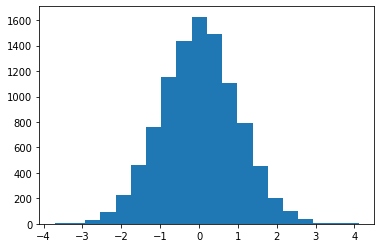

In [26]:
plt.hist(x,bins=20)

(array([1.17737761e-04, 8.71259429e-04, 2.09573214e-03, 8.83033205e-03,
        2.56668318e-02, 6.24952033e-02, 1.30900842e-01, 2.16990693e-01,
        3.19163522e-01, 3.85379238e-01, 3.88134302e-01, 3.31007940e-01,
        2.34062668e-01, 1.38012203e-01, 6.84762816e-02, 2.88928465e-02,
        9.86642434e-03, 2.89634891e-03, 7.29974116e-04, 1.64832865e-04]),
 array([-4.27600576, -3.85133317, -3.42666058, -3.00198799, -2.57731539,
        -2.1526428 , -1.72797021, -1.30329762, -0.87862503, -0.45395243,
        -0.02927984,  0.39539275,  0.82006534,  1.24473794,  1.66941053,
         2.09408312,  2.51875571,  2.9434283 ,  3.3681009 ,  3.79277349,
         4.21744608]),
 <BarContainer object of 20 artists>)

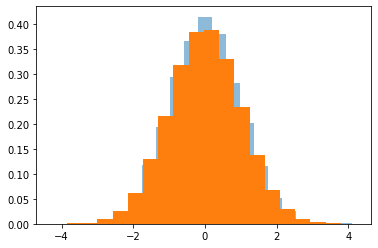

In [25]:
plt.hist(x,bins=20,density=True,alpha=0.5)
plt.hist(automatc_samples[:,0],bins=20,density=True)

In [3]:
pip install lightweight_mmm

Note: you may need to restart the kernel to use updated packages.Collecting lightweight_mmm

  Obtaining dependency information for lightweight_mmm from https://files.pythonhosted.org/packages/e9/4f/4de01b34a2b22303a0b694f98457632ea689767b5e79d0657898de8c2b37/lightweight_mmm-0.1.9-py3-none-any.whl.metadata
  Using cached lightweight_mmm-0.1.9-py3-none-any.whl.metadata (18 kB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Obtaining dependency information for immutabledict>=2.0.0 from https://files.pythonhosted.org/packages/63/24/2d70ce3bca941be9d81e7e701918b5eb4655e74f5ce7453d3fb6760edfa3/immutabledict-2.2.5-py3-none-any.whl.metadata
  Using cached immutabledict-2.2.5-py3-none-any.whl.metadata (3.2 kB)
  Using cached matplotlib-3.6.1-cp39-cp39-win_amd64.whl (7.2 MB)
  Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/2d/30/3afb8bcb785653254eb646ff2680ec4d637b40b06f4b046aca17b5

In [7]:
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import optimize_media
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

c:\Users\61401\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [55]:
import pandas as pd
df=pd.read_csv("https://raw.githubusercontent.com/sibylhe/mmm_stan/main/data.csv")

In [56]:
mdsp_cols=[col for col in df.columns if 'mdsp' in col and col !='mdsp_viddig' and col != 'mdsp_auddig' and col != 'mdsp_sem']
holiday_co=[col for col in df.columns if 'hldy' in col]
seas_col=[col for col in df.columns if 'seas' in col]
control_variable=holiday_co+seas_col
sales_col=['sales']

In [57]:
df_main = df[['wk_strt_dt']+sales_col+mdsp_cols+control_variable]
df_main = df_main.rename(columns={'mdsp_dm': 'Direct Mail', 'mdsp_inst': 'Insert', 'mdsp_nsp': 'Newspaper', 'mdsp_audtr': 'Radio', 'mdsp_vidtr': 'TV', 'mdsp_so': 'Social Media', 'mdsp_on': 'Online Display'})
mdsp_cols = ["Direct Mail","Insert", "Newspaper", "Radio", "TV", "Social Media", "Online Display"]

In [58]:
data_size=df.shape[0]
n_media_channel=len(mdsp_cols)
n_extra_features=len(control_variable)
media_data=df_main[mdsp_cols].to_numpy()
extra_feature=df_main[control_variable].to_numpy()
target=df_main[sales_col].to_numpy()
cost=df_main[mdsp_cols].sum().to_numpy()

test_data_period_size=24
split_point=data_size-test_data_period_size


media_data_train=media_data[:split_point,]
media_data_test=media_data[split_point:,]

extra_feature_train=extra_feature[:split_point,]
extra_feature_test=extra_feature[split_point:,]

target_train=target[:split_point]
target_test=target[split_point:]



In [59]:
cost

array([1.58373363e+08, 1.66102455e+07, 5.32036266e+07, 2.56247164e+07,
       3.51451521e+07, 2.13202038e+07, 4.51155756e+07])

In [53]:
media_scalar=preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_scalar=preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scalar=preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)


media_data_train=media_scalar.fit_transform(media_data_train)

extra_feature_train=extra_scalar.fit_transform(extra_feature_train)

target_train=target_scalar.fit_transform(target_train)

cost=cost_scaler.fit_transform(cost)


In [71]:
mmm = lightweight_mmm.LightweightMMM(model_name="hill_adstock")
mmm.fit( media=media_data_train, media_prior=cost, target=target_train, extra_features=extra_feature_train, media_names = mdsp_cols, seed=105,number_warmup=2000,number_samples=2000)

c:\Users\61401\AppData\Local\Programs\Python\Python39\lib\site-packages\lightweight_mmm\lightweight_mmm.py:358: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 4000/4000 [12:17<00:00,  5.42it/s, 1023 steps of size 6.22e-05. acc. prob=0.88]


In [72]:
mmm.print_summary()


                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
             coef_extra_features[0]      0.29      0.51      0.29     -0.22      0.80      1.00    458.64
             coef_extra_features[1]     -0.27      0.20     -0.27     -0.48     -0.07      1.00    192.87
             coef_extra_features[2]      0.47      0.52      0.47     -0.05      0.99      1.00    586.55
             coef_extra_features[3]     -0.41      0.43     -0.41     -0.85      0.02      1.00    709.01
             coef_extra_features[4]      0.50      0.15      0.50      0.34      0.65      1.00    343.53
             coef_extra_features[5]      0.39      0.10      0.39      0.29      0.49      1.00    165.50
             coef_extra_features[6]     -0.01      0.16     -0.01     -0.18      0.15      1.00    231.50
             coef_extra_features[7]      0.51      0.37      0.51      0.14      0.89      1.00    769.96
             coef_extra_features[8]      0.22

TypeError: sub got incompatible shapes for broadcasting: (185, 1), (2000, 185).

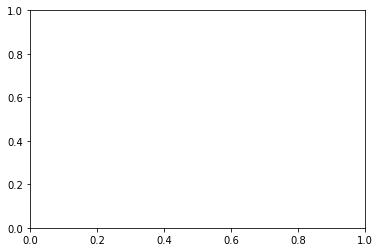

In [68]:
plot.plot_model_fit(mmm, target_scaler=target_scalar)

In [74]:
import pandas as pd

# I am not sure whether this data set is real, dummy, or simulated data, but for me, it looks more realistic than any other data I found on the internet.
df = pd.read_csv("https://raw.githubusercontent.com/sibylhe/mmm_stan/main/data.csv")

# 1. media variables
# media spending (Simplified media channel for demo)
mdsp_cols=[col for col in df.columns if 'mdsp_' in col and col !='mdsp_viddig' and col != 'mdsp_auddig' and col != 'mdsp_sem']

# 2. control variables
# holiday variables
hldy_cols = [col for col in df.columns if 'hldy_' in col]
# seasonality variables
seas_cols = [col for col in df.columns if 'seas_' in col]

control_vars =  hldy_cols + seas_cols

# 3. sales variables
sales_cols =['sales']

df_main = df[['wk_strt_dt']+sales_cols+mdsp_cols+control_vars]
df_main = df_main.rename(columns={'mdsp_dm': 'Direct Mail', 'mdsp_inst': 'Insert', 'mdsp_nsp': 'Newspaper', 'mdsp_audtr': 'Radio', 'mdsp_vidtr': 'TV', 'mdsp_so': 'Social Media', 'mdsp_on': 'Online Display'})
mdsp_cols = ["Direct Mail","Insert", "Newspaper", "Radio", "TV", "Social Media", "Online Display"]
SEED = 105
data_size = len(df_main)

n_media_channels = len(mdsp_cols)
n_extra_features = len(control_vars)
media_data = df_main[mdsp_cols].to_numpy()
extra_features = df_main[control_vars].to_numpy()
target = df_main['sales'].to_numpy()
costs = df_main[mdsp_cols].sum().to_numpy()

# Split and scale data.
test_data_period_size = 24
split_point = data_size - test_data_period_size
# Media data
media_data_train = media_data[:split_point, ...]
media_data_test = media_data[split_point:, ...]
# Extra features
extra_features_train = extra_features[:split_point, ...]
extra_features_test = extra_features[split_point:, ...]
# Target
target_train = target[:split_point]
media_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean, multiply_by=0.15)

media_data_train = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train = target_scaler.fit_transform(target_train)
costs = cost_scaler.fit_transform(costs)
mmm = lightweight_mmm.LightweightMMM(model_name="hill_adstock")
mmm.fit( media=media_data_train, media_prior=costs, target=target_train, extra_features=extra_features_train, number_warmup=3000, number_samples=3000, media_names = mdsp_cols, seed=SEED)

c:\Users\61401\AppData\Local\Programs\Python\Python39\lib\site-packages\lightweight_mmm\lightweight_mmm.py:358: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 6000/6000 [07:51<00:00, 12.72it/s, 1023 steps of size 1.36e-03. acc. prob=0.96]


In [75]:
mmm.print_summary()


                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
             coef_extra_features[0]      0.03      0.82      0.00     -1.28      1.40    909.15      1.00
             coef_extra_features[1]     -0.00      0.70      0.00     -1.17      1.17    609.47      1.00
             coef_extra_features[2]     -0.01      0.01     -0.02     -0.03     -0.00    733.58      1.00
             coef_extra_features[3]      0.00      0.00      0.00     -0.00      0.01   1346.04      1.00
             coef_extra_features[4]     -0.02      0.69     -0.03     -1.16      1.12    508.58      1.00
             coef_extra_features[5]      0.02      0.70      0.01     -1.19      1.15    609.71      1.00
             coef_extra_features[6]     -0.01      0.00     -0.01     -0.01     -0.00   1532.66      1.00
             coef_extra_features[7]     -0.00      0.00     -0.00     -0.01      0.00   1294.14      1.00
             coef_extra_features[8]     -0.02

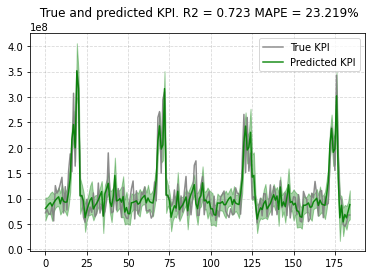

In [76]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

In [78]:
pip install statsmodels

In [79]:
import statsmodels

In [ ]:
from statsmodels.tsa.stattools import adfuller
def stationary_check(series):
    X=series.values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [82]:
alpha_1 = 0.5
import numpy as np
np.random.seed(SEED)
ar = np.r_[1, -np.array([alpha_1])] # add zero-lag and negate
ma = np.r_[1] # add zero-lag

In [ ]:
from statsmodels.tsa.ar

In [ ]:
np.

In [84]:
a=statsmodels.tsa.arima_process.arma_generate_sample(ar,ma,1000)
plt.scatter(a)

AttributeError: module 'statsmodels.tsa' has no attribute 'arima_process'

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf